# Model Training and Evaluation - Nutrition Classification

This notebook trains and evaluates multiple machine learning models for nutrition classification.


In [1]:
# Import libraries
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from src.data.preprocessing import NutritionPreprocessor
from src.models.train import NutritionClassifier, get_default_param_grids
from src.models.evaluate import ModelEvaluator
from src.utils.interpretability import ModelInterpreter, get_top_features_by_importance

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


## 1. Load and Prepare Data

We'll load Open Food Facts data, clean it, engineer features, and create classification labels.


In [2]:
# Load data from Parquet
from src.data.data_loader import NutritionDataLoader

loader = NutritionDataLoader(processed_dir='../data/processed')

# Load Open Food Facts data (use sample for faster training)
df_raw = loader.load_open_food_facts(sample_size=50000)  # Adjust sample size as needed

print(f"Loaded {len(df_raw):,} products")
print(f"Columns: {df_raw.columns.tolist()}")


self.processed_dir: ../data/processed
parquet_path: ../data/processed/openfoodfactsproducts.parquet
parquet_path.exists(): True
Loading Open Food Facts from Parquet...
✓ Loaded 50,000 products
Loaded 50,000 products
Columns: ['product_name', 'brands', 'categories', 'countries', 'nutrition_grade_fr', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']


## 2. Data Preprocessing and Feature Engineering


In [3]:
# Initialize preprocessor
preprocessor = NutritionPreprocessor()

# Clean data
print("Step 1: Cleaning data...")
df_clean = preprocessor.clean_data(df_raw, drop_threshold=0.7)

# Engineer features
print("\nStep 2: Engineering features...")
df_features = preprocessor.engineer_features(df_clean)

print(f"\nProcessed data shape: {df_features.shape}")
print(f"Available features: {df_features.columns.tolist()}")


Step 1: Cleaning data...
Cleaning data...
Data cleaned: 50000 -> 41866 rows

Step 2: Engineering features...
Engineering features...
Features engineered: 13 -> 22 columns

Processed data shape: (41866, 22)
Available features: ['product_name', 'brands', 'countries', 'nutrition_grade_fr', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'energy_density', 'fat_ratio', 'carb_ratio', 'protein_ratio', 'sugar_density', 'sugar_fiber_ratio', 'saturated_fat_ratio', 'sodium_density', 'protein_density']


In [4]:
## 3. Create Classification Labels

#Create both binary and multiclass labels as per proposal.


In [5]:
# Create labels

# Binary classification: Healthy vs Unhealthy
print("Creating binary labels (Healthy/Unhealthy)...")
df_features['healthy'] = preprocessor.create_binary_labels(df_features)

# Multiclass classification: Low/Medium/High for each nutrient
from src.data.preprocessing import NUTRIENT_THRESHOLDS

print("\nCreating multiclass labels...")
if 'sugars_100g' in df_features.columns:
    df_features['sugar_class'] = preprocessor.create_nutrient_labels(
        df_features, 'sugars_100g', NUTRIENT_THRESHOLDS.get('sugars_100g')
    )
    
if 'fiber_100g' in df_features.columns:
    df_features['fiber_class'] = preprocessor.create_nutrient_labels(
        df_features, 'fiber_100g', NUTRIENT_THRESHOLDS.get('fiber_100g')
    )
    
if 'proteins_100g' in df_features.columns:
    df_features['protein_class'] = preprocessor.create_nutrient_labels(
        df_features, 'proteins_100g', NUTRIENT_THRESHOLDS.get('proteins_100g')
    )
    
if 'sodium_100g' in df_features.columns:
    df_features['sodium_class'] = preprocessor.create_nutrient_labels(
        df_features, 'sodium_100g', NUTRIENT_THRESHOLDS.get('sodium_100g')
    )

print("\nLabel distributions:")
print("\nHealthy/Unhealthy:")
print(df_features['healthy'].value_counts())

if 'sugar_class' in df_features.columns:
    print("\nSugar classes (0=Low, 1=Medium, 2=High):")
    print(df_features['sugar_class'].value_counts().sort_index())


Creating binary labels (Healthy/Unhealthy)...

Creating multiclass labels...

Label distributions:

Healthy/Unhealthy:
healthy
0    39165
1     2701
Name: count, dtype: int64

Sugar classes (0=Low, 1=Medium, 2=High):
sugar_class
0    19366
1    12409
2    10091
Name: count, dtype: int64


## 4. Choose Classification Task and Prepare Train/Test Split


In [ ]:
# Choose classification task
# Options: 'healthy' (binary), 'sugar_class', 'fiber_class', 'protein_class', 'sodium_class' (multiclass)
TASK = 'sugar_class'  # Change this to train different tasks

print(f"Training task: {TASK}")
print("="*70)

# Define label columns
label_cols = ['healthy', 'sugar_class', 'fiber_class', 'protein_class', 'sodium_class', 
              'product_name', 'brands', 'categories', 'countries', 'nutrition_grade_fr']

# Define feature columns
feature_cols = [col for col in df_features.columns if col not in label_cols]

# IMPORTANT: Exclude leaky features to prevent data leakage
leaky_features = preprocessor.get_leaky_features(TASK)
if leaky_features:
    print(f"\n🔒 Preventing data leakage:")
    print(f"   Excluding features: {leaky_features}")
    feature_cols = [col for col in feature_cols if col not in leaky_features]
    print(f"   Features remaining: {len(feature_cols)}")

# Prepare X and y
X = df_features[feature_cols].copy()
y = df_features[TASK].copy()

# Remove samples with missing labels
mask = ~y.isnull()
X = X[mask]
y = y[mask]

print(f"\nFeatures: {len(feature_cols)}")
print(f"Feature names: {feature_cols}")
print(f"\nSamples: {len(X):,}")
print(f"\nLabel distribution:")
print(y.value_counts().sort_index())

# Determine task type
task_type = 'binary' if y.nunique() == 2 else 'multiclass'
print(f"\nTask type: {task_type}")
print(f"Number of classes: {y.nunique()}")


Training task: sugar_class
Features: 18
Feature names: ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'energy_density', 'fat_ratio', 'carb_ratio', 'protein_ratio', 'sugar_density', 'sugar_fiber_ratio', 'saturated_fat_ratio', 'sodium_density', 'protein_density']

Samples: 41,866

Label distribution:
sugar_class
0    19366
1    12409
2    10091
Name: count, dtype: int64

Task type: multiclass
Number of classes: 3


In [7]:
# Split data: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train  # 0.25 of 0.8 = 0.2 overall
)

print(f"Training set: {len(X_train):,} samples")
print(f"Validation set: {len(X_val):,} samples")
print(f"Test set: {len(X_test):,} samples")

# Normalize features
X_train_scaled, X_val_scaled = preprocessor.normalize_features(X_train, X_val)
_, X_test_scaled = preprocessor.normalize_features(X_train, X_test)  # Use same scaler as training

print("\n✓ Data prepared and normalized")


Training set: 25,119 samples
Validation set: 8,373 samples
Test set: 8,374 samples
Normalizing features...
Normalizing features...

✓ Data prepared and normalized


## 5. Train Multiple Models

Train all models as specified in the proposal:
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost
- Multi-Layer Perceptron (MLP)


In [8]:
# Initialize classifier
classifier = NutritionClassifier(task_type=task_type)

print("Training models...")
print("="*70)

# Train all models
results = classifier.train_models(
    X_train_scaled, y_train,
    X_val_scaled, y_val
)

print("\n✓ All models trained!")
print(f"\nTrained models: {list(classifier.models.keys())}")


Training models...

Training models for multiclass classification...
Training set size: 25119
Number of features: 18
Label distribution:
sugar_class
0    11619
1     7445
2     6055
Name: count, dtype: int64

Training Logistic Regression...
  Train accuracy: 0.9906
  Val accuracy: 0.9916

Training Decision Tree...
  Train accuracy: 1.0000
  Val accuracy: 1.0000

Training Random Forest...
  Train accuracy: 1.0000
  Val accuracy: 1.0000

Training XGBoost...
  Train accuracy: 1.0000
  Val accuracy: 0.9976

Training MLP...
  Train accuracy: 0.9971
  Val accuracy: 0.9939

Best model: Decision Tree (val_score: 1.0000)

✓ All models trained!

Trained models: ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'MLP']


## 6. Evaluate Models on Test Set

Evaluate using metrics from the proposal:
- Accuracy
- Macro-F1 Score
- Confusion Matrices
- Per-class metrics


In [9]:
# Initialize evaluator
evaluator = ModelEvaluator(task_type=task_type)

# Compare all models
print("Evaluating models on test set...")
print("="*70)

comparison_df = evaluator.compare_models(classifier.models, X_test_scaled, y_test)

print("\nMODEL COMPARISON (Test Set)")
print(comparison_df.round(4))

# Find best model based on F1-Score
best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
best_f1 = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'F1-Score']
best_acc = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Accuracy']

print(f"\n🏆 Best model: {best_model_name}")
print(f"   F1-Score (Macro): {best_f1:.4f}")
print(f"   Accuracy: {best_acc:.4f}")


Evaluating models on test set...

MODEL COMPARISON

Evaluating Logistic Regression

Overall Metrics:
  Accuracy:  0.9893
  Precision: 0.9880
  Recall:    0.9915
  F1 Score:  0.9896
  ROC AUC:   0.9997

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3874
           1       0.97      1.00      0.98      2482
           2       1.00      1.00      1.00      2018

    accuracy                           0.99      8374
   macro avg       0.99      0.99      0.99      8374
weighted avg       0.99      0.99      0.99      8374


Confusion Matrix:
[[3798   76    0]
 [   1 2472    9]
 [   0    4 2014]]

Evaluating Decision Tree

Overall Metrics:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1 Score:  1.0000
  ROC AUC:   1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3874
           1       1.00      1.00      1.00

## 7. Visualize Model Performance


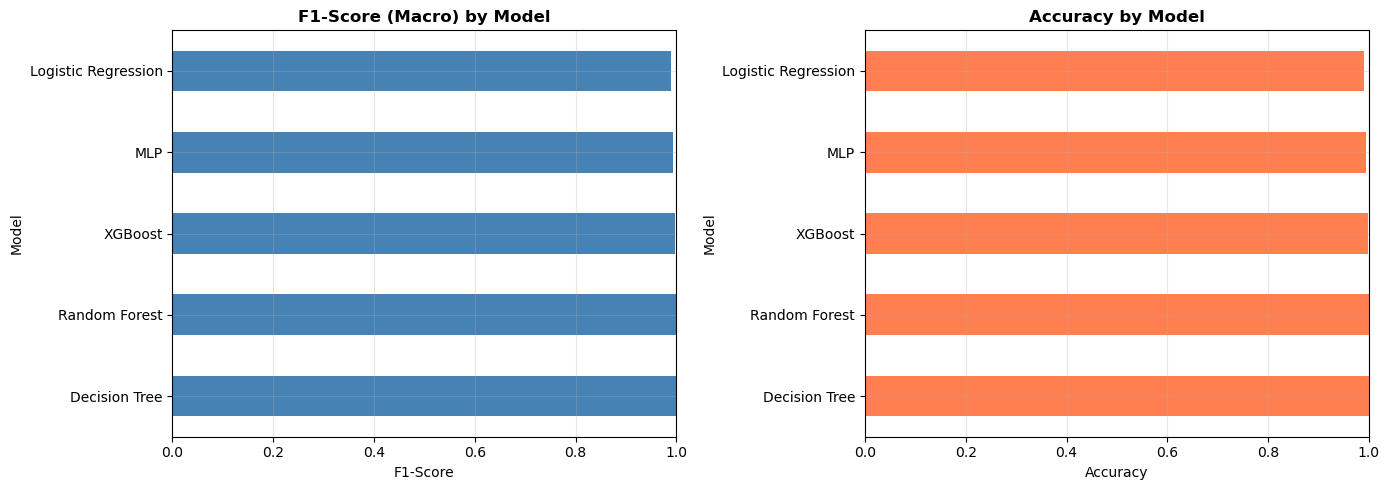

In [10]:
# Plot model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Set Model as index for plotting
plot_df = comparison_df.set_index('Model')

# F1-Score comparison
plot_df['F1-Score'].plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('F1-Score (Macro) by Model', fontweight='bold')
axes[0].set_xlabel('F1-Score')
axes[0].set_xlim([0, 1])
axes[0].grid(True, alpha=0.3)

# Accuracy comparison
plot_df['Accuracy'].plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Accuracy by Model', fontweight='bold')
axes[1].set_xlabel('Accuracy')
axes[1].set_xlim([0, 1])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Confusion Matrices for Best Models


In [11]:
# Plot confusion matrices for top 3 models
top_3_models = comparison_df.nlargest(3, 'F1-Score')['Model'].tolist()

print(f"Plotting confusion matrices for top 3 models: {top_3_models}")

# Plot confusion matrix for each top model
for model_name in top_3_models:
    evaluator.plot_confusion_matrix(model_name)
    plt.show()


Plotting confusion matrices for top 3 models: ['Decision Tree', 'Random Forest', 'XGBoost']


TypeError: object of type 'NoneType' has no len()

<Figure size 800x600 with 0 Axes>

## 9. Model Interpretability - Feature Importance

Analyze which features are most important for classification.


In [ ]:
# Get feature importance for tree-based models
tree_models = ['Random Forest', 'XGBoost', 'Decision Tree']
available_tree_models = [m for m in tree_models if m in classifier.models]

if available_tree_models:
    print("Feature Importance (Tree-based models)")
    print("="*70)
    
    interpreter = ModelInterpreter()
    
    for model_name in available_tree_models:
        print(f"\n{model_name}:")
        print("-"*70)
        
        importance_df = interpreter.get_feature_importance(
            classifier.models[model_name],
            feature_cols,
            top_n=15
        )
        
        print(importance_df)
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
        plt.xlabel('Importance')
        plt.title(f'Top 15 Features - {model_name}', fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()


## 10. SHAP Analysis (Advanced Interpretability)

Use SHAP values to understand model predictions.


In [ ]:
# SHAP analysis for best model
try:
    import shap
    
    print(f"Computing SHAP values for {best_model_name}...")
    best_model = classifier.models[best_model_name]
    
    # Use a sample for SHAP (it can be slow)
    X_shap = X_test_scaled.sample(min(500, len(X_test_scaled)), random_state=42)
    
    # Compute SHAP values
    interpreter = ModelInterpreter()
    shap_values = interpreter.compute_shap_values(best_model, X_shap, feature_cols)
    
    # Plot SHAP summary
    print("\nSHAP Summary Plot:")
    interpreter.plot_shap_summary(shap_values, X_shap, feature_cols)
    
except ImportError:
    print("SHAP not installed. Install with: pip install shap")
    print("Skipping SHAP analysis...")
except Exception as e:
    print(f"Error computing SHAP values: {e}")
    print("Skipping SHAP analysis...")


## 11. Save Best Model


In [ ]:
# Save the best model
import joblib
from pathlib import Path

# Create models directory
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

# Save model
model_path = models_dir / f'best_model_{TASK}.pkl'
joblib.dump(classifier.models[best_model_name], model_path)

# Save scaler
scaler_path = models_dir / f'scaler_{TASK}.pkl'
joblib.dump(preprocessor.scaler, scaler_path)

# Save feature names
features_path = models_dir / f'features_{TASK}.pkl'
joblib.dump(feature_cols, features_path)

print(f"✓ Saved best model ({best_model_name}) to: {model_path}")
print(f"✓ Saved scaler to: {scaler_path}")
print(f"✓ Saved feature names to: {features_path}")


## 12. Summary of Results


In [ ]:
# Print comprehensive summary
print("="*70)
print(f"CLASSIFICATION RESULTS SUMMARY - {TASK.upper()}")
print("="*70)
print(f"\nTask Type: {task_type}")
print(f"Number of Classes: {y.nunique()}")
print(f"Training Samples: {len(X_train):,}")
print(f"Test Samples: {len(X_test):,}")
print(f"Features Used: {len(feature_cols)}")

print("\n" + "-"*70)
print("MODEL PERFORMANCE ON TEST SET:")
print("-"*70)
print(comparison_df.round(4))

print("\n" + "-"*70)
print(f"BEST MODEL: {best_model_name}")
print("-"*70)
best_row = comparison_df[comparison_df['Model'] == best_model_name].iloc[0]
print(f"Accuracy:  {best_row['Accuracy']:.4f}")
print(f"F1-Score:  {best_row['F1-Score']:.4f}")
print(f"Precision: {best_row['Precision']:.4f}")
print(f"Recall:    {best_row['Recall']:.4f}")

print("\n" + "="*70)
print("✓ Training Complete!")
print("="*70)

# Suggestions for next steps
print("\n📋 NEXT STEPS:")
print("1. Change TASK variable to train other classification tasks")
print("2. Adjust sample_size for full dataset training")
print("3. Try hyperparameter tuning using classifier.hyperparameter_tuning()")
print("4. Compare results across different nutrient classifications")
print("5. Use saved model for predictions on new data")


## 3. Train Models


In [ ]:
# Determine task type
task_type = 'binary' if TASK == 'healthy' else 'multiclass'

# Initialize classifier
classifier = NutritionClassifier(task_type=task_type)

# Train all models
results = classifier.train_models(X_train_scaled, y_train, X_val_scaled, y_val)

print(f"\nBest model: {classifier.best_model_name}")


## 4. Evaluate Models


In [ ]:
# Initialize evaluator
evaluator = ModelEvaluator(task_type=task_type)

# Compare all models on test set
comparison_df = evaluator.compare_models(classifier.models, X_test_scaled, y_test)
comparison_df


In [ ]:
# Plot confusion matrix for best model
fig = evaluator.plot_confusion_matrix(
    classifier.best_model_name, 
    class_names=['Low', 'Medium', 'High'] if task_type == 'multiclass' else ['Unhealthy', 'Healthy']
)
plt.show()


## 5. Model Interpretability


In [ ]:
# Feature importance for tree-based models
best_model = classifier.best_model
if hasattr(best_model, 'feature_importances_'):
    fig = evaluator.plot_feature_importance(best_model, X_train.columns.tolist(), top_n=15)
    plt.show()
    
    # Print top features
    top_features = get_top_features_by_importance(best_model, X_train.columns.tolist(), top_n=10)
    print("\nTop 10 Most Important Features:")
    print(top_features)


## 6. Save Best Model


In [ ]:
# Save the best model
model_path = f'../models/best_model_{TASK}.joblib'
classifier.save_model(classifier.best_model_name, model_path)

print(f"Model saved to {model_path}")
